In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:

bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/translation/25h9_s_z_2-4-6-8-10_720_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8,10]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,1.960545
1,1.072042,1.997144
2,1.399024,1.996068
3,1.724036,1.996194
4,2.030176,2.005255
...,...,...
1148,120.498550,10.162689
1149,127.021808,1.776928
1150,127.117690,1.678446
1151,127.217435,1.556955


<AxesSubplot:xlabel='relative_time'>

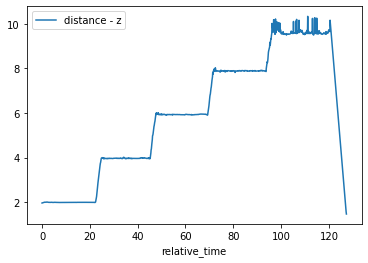

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .25)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

268

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

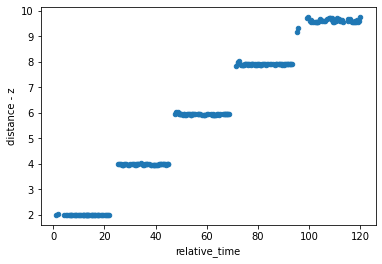

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
len(df_filtered_by_targets)

268

In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
1,1.072042,1.997144,2,0.002856
4,2.030176,2.005255,2,-0.005255
210,25.190984,3.996442,4,0.003558
213,25.500976,3.991022,4,0.008978
433,47.629466,5.962003,6,0.037997
435,47.827514,6.010240,6,-0.010240
667,71.399283,7.821978,8,0.178022
673,72.003427,7.974796,8,0.025204
900,95.292998,9.171560,10,0.828440
904,95.710317,9.328845,10,0.671155


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,48.0,0.009053,0.003349,-0.005255,0.007929,0.008539,0.010025,0.015483
4,52.0,0.027407,0.011466,-0.011467,0.022708,0.030162,0.036435,0.048881
6,56.0,0.061099,0.018768,-0.012514,0.054233,0.066275,0.072211,0.083732
8,62.0,0.102019,0.025637,-0.029328,0.097607,0.103683,0.111896,0.178022
10,50.0,0.395284,0.096413,0.258516,0.338438,0.403032,0.434327,0.828440


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

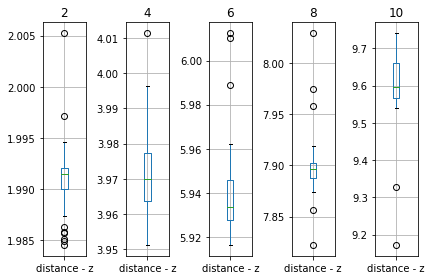

In [16]:
box_plotter(target)

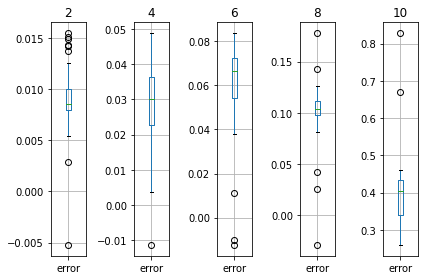

In [17]:
box_plotter('error')

In [18]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/translations/result/csv/25h9_720.csv')